In [1]:
# lets start with importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve
import joblib

In [2]:
# lets read the dataset
df = pd.read_csv('C:/Users/BatuhanYILMAZ/Desktop/staj/project_1/datasets/preprocessed_winszorization_without_duration.csv')
df.head()

,age,balance,day,campaign,job,month,marital_divorced,marital_married,marital_single,education_primary,...,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
0,27,-172,3,1,4,8,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
1,27,-172,3,1,9,8,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,27,-172,3,1,2,8,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,27,-172,3,1,1,8,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
4,27,-172,3,1,11,8,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [3]:
# lets divide the dataset into independent-dependent variables
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]

In [4]:
# split the dataset into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# lets implement the grid search for random forest algorithm just as we have done for logistic regression.
# since random forest is a robust algorithm agains the imbalanced dataasets, there is no need for extra tuning.

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [150, 250],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'class_weight': [None, {0: 0.12, 1: 0.88}]
}
# Define the scoring metric (recall)
scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(
    rf,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# Fit the grid search on the data
grid_search_rf.fit(X_train, y_train)

# Get the best estimator from the grid search
best_model_rf = grid_search_rf.best_estimator_
best_param_rf = grid_search_rf.best_params_

# Perform cross-validation and get recall scores
cross_val_recall_scores_rf = grid_search_rf.cv_results_['mean_test_score']

# Calculate average recall score from cross-validation
avg_recall_cross_val_rf = cross_val_recall_scores_rf.max()  # Use max because scoring is recall

# Make predictions on the test set
y_pred_rf = best_model_rf.predict(X_test)

# Print best hyperparameters, cross-validation recall, and test recall
print("Best Hyperparameters:", best_param_rf)
print("Average Recall from Cross-Validation:", avg_recall_cross_val_rf)

# Print classification report
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'class_weight': {0: 0.12, 1: 0.88}, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 250}
Average Recall from Cross-Validation: 0.5371499517566264
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      7952
           1       0.32      0.55      0.40      1091

    accuracy                           0.80      9043
   macro avg       0.63      0.69      0.64      9043
weighted avg       0.86      0.80      0.83      9043



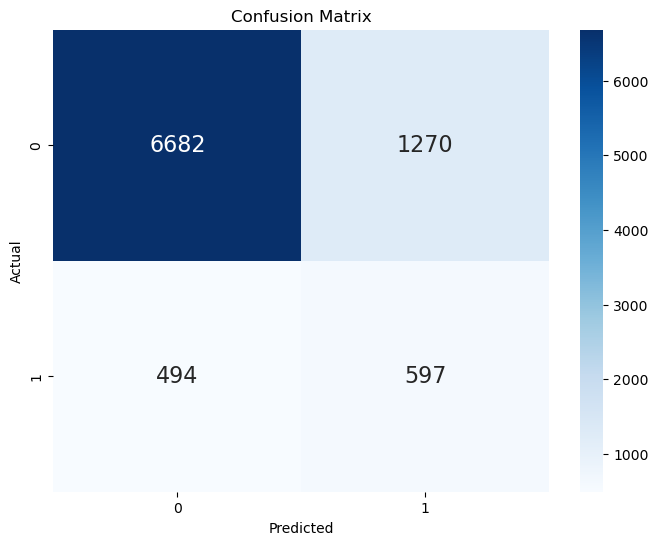

In [6]:
# lets see the confusion matrix as well.
cm = confusion_matrix(y_test, y_pred_rf)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

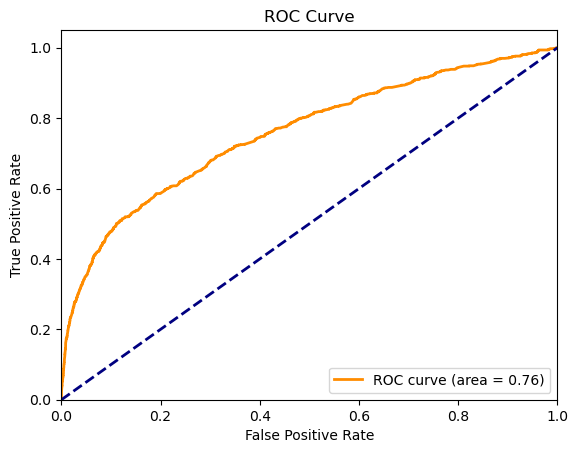

In [7]:
# lets see the ROC curve to see the model's performance at varying levels of discrimination.
y_prob = best_model_rf.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

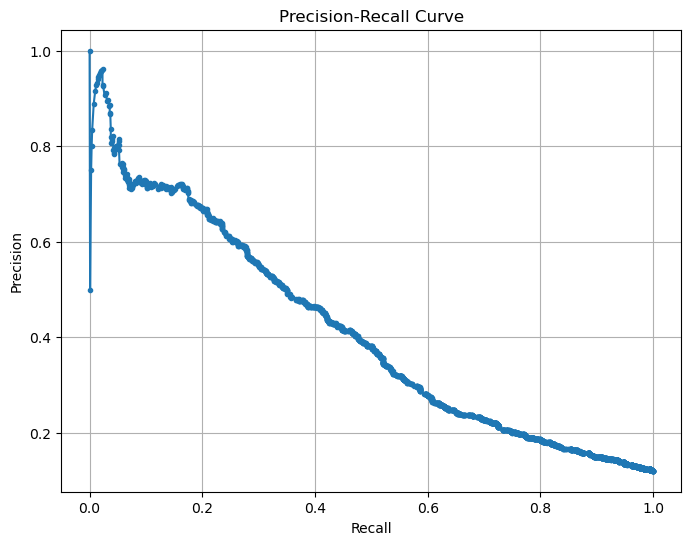

In [8]:
# Get predicted probabilities for the positive class (class 1)
y_scores = best_model_rf.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

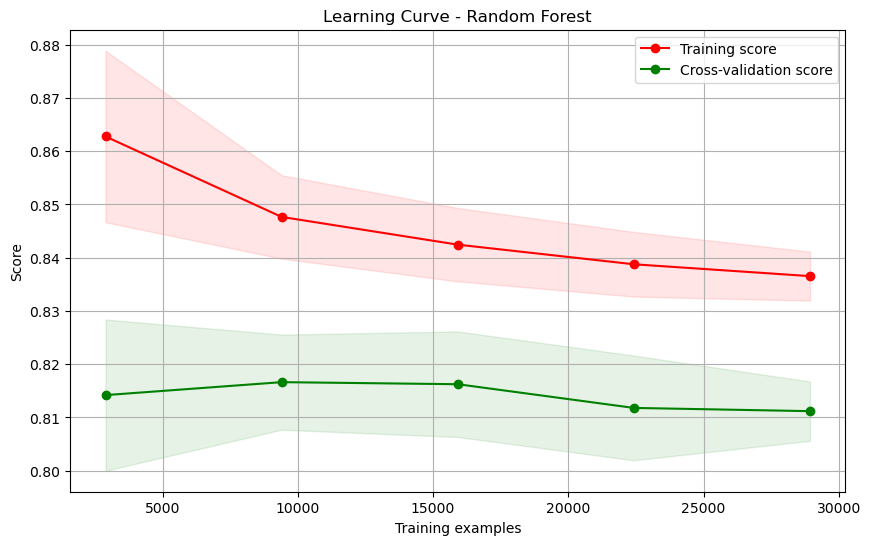

In [9]:
# lets see the learning curve of model at different folds as well to see if it overfits the data
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_model_rf, "Learning Curve - Random Forest", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

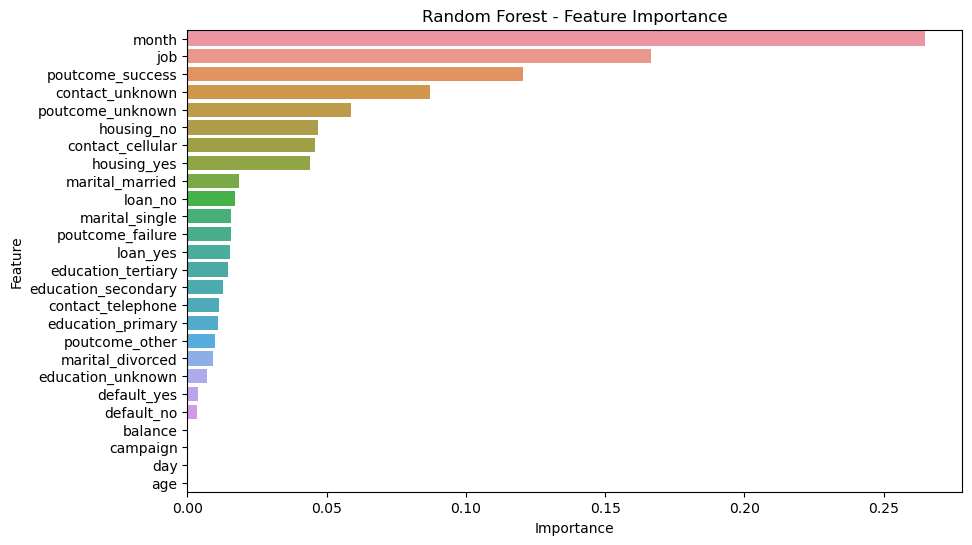

In [10]:
# lets also see the influence of each feature on the output
# Get feature importances
feature_importances = best_model_rf.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Random Forest - Feature Importance")
plt.show()

In [11]:
# save the model for further investigation and usage in future
joblib.dump(best_model_rf, 'best_model_random_forest.pkl')

['best_model_random_forest.pkl']